# Graph quality evaluation
In this notebook, we'll undertake some qualitative and quantitative approaches to evaluating the quality of the various graph generation approaches we've used.

For the sake of this notebooks, "graph quality" refers to the underlying performance of the entity and relation extraction pipelines that are used to build the graph. This decision is based on the assumption that a "gold standard" graph, when built from unstructured scientific articles, is a graph where relations and entities were perfectly extracted from the original source.

In [3]:
import jsonlines
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
plt.rcParams['pdf.fonttype'] = 42
import networkx as nx
from math import comb
from statistics import median
import json
import pandas as pd
from tqdm import tqdm
from os import listdir
from os.path import splitext
import yaml
import spacy
from spacy import displacy
from pathlib import Path
import random
import pandas as pd
from ast import literal_eval

/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-05-29 21:40:50.093135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 21:40:53.972722: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dr

## Use PICKLE dataset as a baseline quantitative metric
While we don't have a gold standard of entities and relations for our drought/desiccation dataset, we do have access to the [PICKLE dataset](https://huggingface.co/datasets/slotreck/pickle), which has a gold-standard set of entities and relations labeled on 250 plant science abstracts. We'll use the PICKLE dataset to set an expectation for what quantity and ratio of entities and relations we think we should see in our larger drought/desiccation corpus. If our graphs fall far short of the kind of relation/entity ratio that we see in PICKLE, we can say that likely, the recall of the method(s) is poor.

To provide more compelling evidence that PICKLE is a reasonable comparison to our drought/desiccation dataset, we'll also do some comparisons of more basic statistics like abstract length, average word length, and average sentence length.

In [2]:
with jsonlines.open('../data/pickle/pickle_all.jsonl') as reader:
    pickle = [obj for obj in reader]

In [3]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    drought_des = [obj for obj in reader]

In [4]:
datasets = {
    'PICKLE': pickle,
    'drought + desiccation': drought_des
}

### Basic dataset comparisons

In [5]:
abstract_lens = defaultdict(list)
sent_lens = defaultdict(list)
word_lens = defaultdict(list)
for dset_name, dataset in datasets.items():
    for doc in dataset:
        abstract_lens[dset_name].append(len(doc['sentences']))
        for sent in doc['sentences']:
            sent_lens[dset_name].append(len(sent))
            for tok in sent:
                word_lens[dset_name].append(len(tok))
basic_stats = {
    'sentences per abstract': abstract_lens,
    'words per sentence': sent_lens,
    'letters per word': word_lens
}

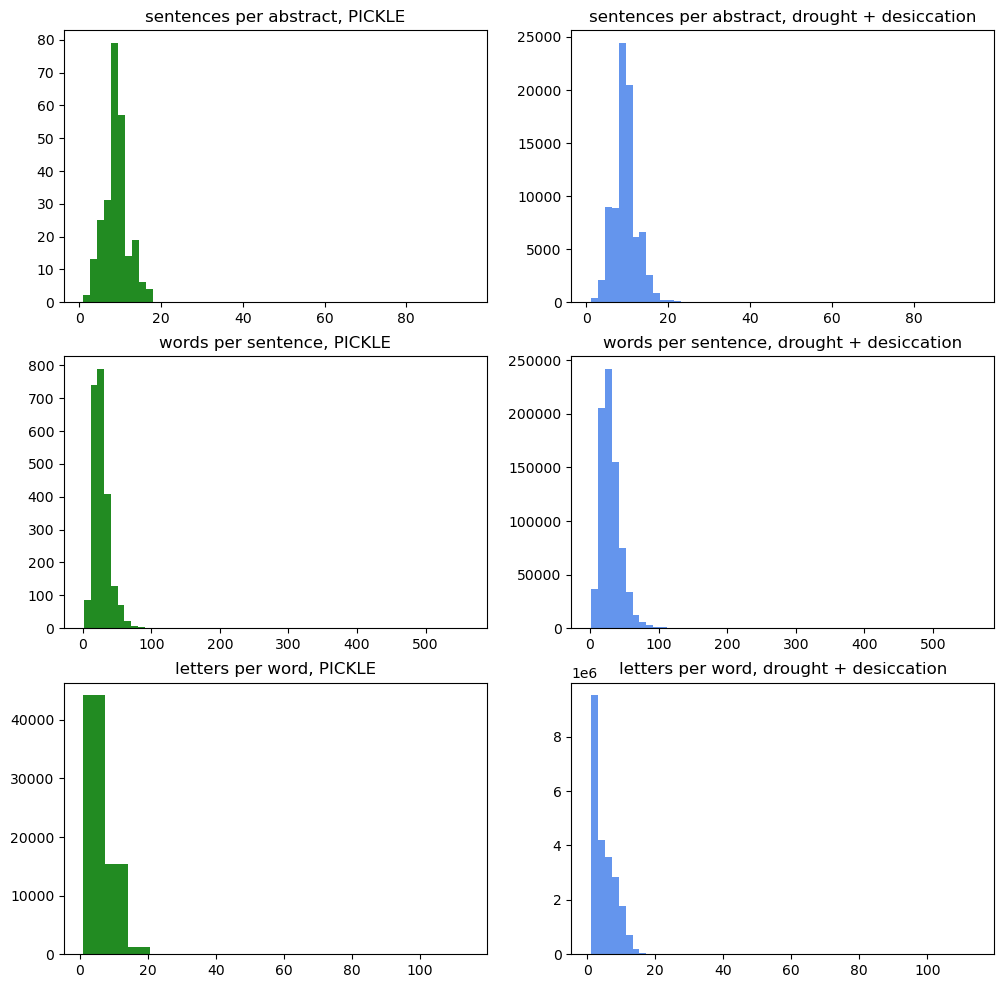

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(12,12), sharex='row')
colors = {'PICKLE': 'forestgreen', 'drought + desiccation': 'cornflowerblue'}
for stat, axz in zip(basic_stats, axs):
    for dset_name, ax in zip(basic_stats[stat], axz):
        vals = basic_stats[stat][dset_name]
        if dset_name == 'PICKLE':
            _, bins, _ = ax.hist(vals, label=dset_name, color=colors[dset_name])
        elif dset_name == 'drought + desiccation':
            ax.hist(vals, bins=len(bins)*5, label=dset_name, color=colors[dset_name])
        ax.set_title(f'{stat}, {dset_name}')
plt.savefig('../data/figures/basic_dataset_statistics_comparison_pickle.pdf', format='pdf',
           bbox_inches='tight', dpi=600)

Figure caption: Histograms of basic dataset statistics for the PICKLE and drought/desiccation dataset. X-limits for each row are determined by the automatic x-limits for the drought/desiccation dataset, as it has larger ourliers in each category. Default number of bins was used for PICKLE, and 5x the number of PICKLE bins was used for drought/desiccation in each row to allow a similar level of granularity for comparison.

In [7]:
max_vals = {
    stat: {
        dset: max(vals)
        for dset, vals in stat_val.items()
    } for stat, stat_val in basic_stats.items()
}

In [8]:
max_vals

{'sentences per abstract': {'PICKLE': 18, 'drought + desiccation': 95},
 'words per sentence': {'PICKLE': 100, 'drought + desiccation': 561},
 'letters per word': {'PICKLE': 66, 'drought + desiccation': 114}}

### Calculation of the ratio
We'll do this both for the overall dataset, as well as on a per-abstract level, so that we can compare distributions as well. We'll start by defining a function to build a networkx graph from the dygiepp predictions, as we need the identical nodes and edges to be contracted before we calculate the overall ratio.

In [9]:
def jsonl_to_nx(dataset, predicted=True):
    """
    Convert a DyGIE++-formatted dataset to a directed graph.
    """
    if predicted:
        ner_key = 'predicted_ner'
        rel_key = 'predicted_relations'
    else:
        ner_key = 'ner'
        rel_key = 'relations'

    nodes = []
    edges = []
    for doc in dataset:
        for sent in doc[ner_key]:
            all_toks = [tok for sent in doc['sentences'] for tok in sent]
            for ent in sent:
                ent_text = ' '.join(all_toks[ent[0]: ent[1]+1]).lower()
                ent_type = ent[2]
                nodes.append((ent_text, {'ent_type': ent_type}))
            for sent in doc[rel_key]:
                for rel in sent:
                    edge = (' '.join(all_toks[rel[0]: rel[1]+1]).lower(), ' '.join(all_toks[rel[2]: rel[3]+1]).lower(),
                                    {'rel_type': rel[4]})
                    edges.append(edge)
    
    graph = nx.DiGraph()
    _ = graph.add_nodes_from(nodes)
    _ = graph.add_edges_from(edges)
    
    return graph

In [10]:
pickle_graph = jsonl_to_nx(pickle, predicted=False)

In [11]:
total_ratio = len(pickle_graph.edges)/len(pickle_graph.nodes)
print(f'The PICKLE dataset has a relation to entity ratio of {total_ratio:.2f}')

The PICKLE dataset has a relation to entity ratio of 0.61


In [12]:
ents_per_abstract = defaultdict(int)
rels_per_abstract = defaultdict(int)
for doc in pickle:
    entcount = 0
    relcount = 0
    for sent in doc['ner']:
        entcount += len(sent)
    for sent in doc['relations']:
        relcount += len(sent)
    ents_per_abstract[doc['doc_key']] = entcount
    rels_per_abstract[doc['doc_key']] = relcount

In [13]:
per_doc_ratios = {doc['doc_key']: rels_per_abstract[doc['doc_key']]/ents_per_abstract[doc['doc_key']] for doc in pickle}

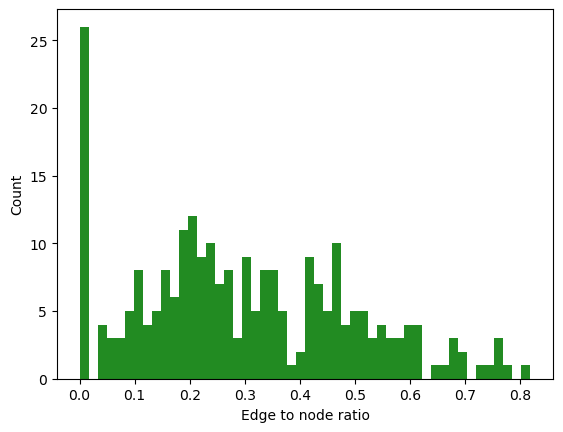

In [14]:
_ = plt.hist(per_doc_ratios.values(), bins=50, color=colors['PICKLE'])
_ = plt.xlabel('Edge to node ratio')
_ = plt.ylabel('Count')

## Evaluating available graphs
### DyGIE++

In [15]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    dygiepp_preds = [obj for obj in reader]

In [16]:
dygiepp_graph = nx.read_graphml('../data/kg/dygiepp_pure_extraction_graph.graphml')

In [17]:
print(f'The DyGIE++-derived graph has {len(dygiepp_graph.nodes)} nodes and {len(dygiepp_graph.edges)} edges.')
print(f'{len(list(nx.isolates(dygiepp_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in dygiepp_graph.degree])}.')

The DyGIE++-derived graph has 336120 nodes and 124408 edges.
268851 of these nodes are isolates, and the median node degree is 0.0.


In [18]:
ents_per_abstract_dygiepp = defaultdict(int)
rels_per_abstract_dygiepp = defaultdict(int)
for doc in dygiepp_preds:
    entcount = 0
    relcount = 0
    for sent in doc['predicted_ner']:
        entcount += len(sent)
    for sent in doc['predicted_relations']:
        relcount += len(sent)
    ents_per_abstract_dygiepp[doc['doc_key']] = entcount
    rels_per_abstract_dygiepp[doc['doc_key']] = relcount

In [19]:
total_ratio_dygiepp = len(dygiepp_graph.edges)/len(dygiepp_graph.nodes)
print(f'The DyGIE++-derived graph has a relation to entity ratio of {total_ratio_dygiepp:.2f}')

The DyGIE++-derived graph has a relation to entity ratio of 0.37


In [20]:
per_doc_ratios_dygiepp = {}
for doc in dygiepp_preds:
    try:
        per_doc_ratios_dygiepp[doc['doc_key']] = rels_per_abstract_dygiepp[doc['doc_key']]/ents_per_abstract_dygiepp[doc['doc_key']]
    except ZeroDivisionError:
        per_doc_ratios_dygiepp[doc['doc_key']] = 0

### DyGIE++ co-occurrence

In [ ]:
dygiepp_co_occurrence = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_02May2024.graphml')

In [ ]:
print(f'The co-occurrence graph has {len(dygiepp_co_occurrence.nodes)} nodes and {len(dygiepp_co_occurrence.edges)} edges.')
print(f'{len(list(nx.isolates(dygiepp_co_occurrence)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in dygiepp_co_occurrence.degree])}.')

In [ ]:
total_ratio_co_occurrence = len(dygiepp_co_occurrence.edges)/len(dygiepp_co_occurrence.nodes)
print(f'The co-occurrence graph has a relation to entity ratio of {total_ratio_co_occurrence:.2f}')

To calculate the ratio on a per-document basis, we need to go back to the predictions:

In [ ]:
per_doc_ratios_co_occurrence = defaultdict(int)
for doc in drought_des:
    ents = 0
    rels = 0
    for sent in doc['predicted_ner']:
        if len(sent) > 1:
            rels += comb(len(sent), 2)
        ents += len(sent)
    try:
        per_doc_ratios_co_occurrence[doc['doc_key']] = rels/ents
    except ZeroDivisionError:
        per_doc_ratios_co_occurrence[doc['doc_key']] = 0

### OpenIE

In [ ]:
openie_graph = nx.read_graphml('../data/kg/openIE_filtered_graph_08May2024.graphml')

In [ ]:
print(f'The OpenIE graph has {len(openie_graph.nodes)} nodes and {len(openie_graph.edges)} edges.')
print(f'{len(list(nx.isolates(openie_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in openie_graph.degree])}.')

In [ ]:
total_ratio_openie = len(openie_graph.edges)/len(openie_graph.nodes)
print(f'The openIE graph has a relation to entity ratio of {total_ratio_openie:.2f}')

Read in the per-doc triples to get the per-doc ratio:

In [ ]:
with open('../data/kg/openIE_per_doc_filtered_triples_21May2024.json') as f:
    filtered_openie_trips = json.load(f)

In [ ]:
per_doc_ratios_openie = {}
for doc, trips in filtered_openie_trips.items():
    ents = []
    num_rels = len(trips)
    for trip in trips:
        ents.append(trip['subject'])
        ents.append(trip['object'])
    unique_ents = set(ents)
    doc_ratio = num_rels/len(unique_ents)
    per_doc_ratios_openie[doc] = doc_ratio

### OntoGPT

In [ ]:
ontogpt_graph = nx.read_graphml('../data/kg/ontogpt_cleaned_graph_22May2024.graphml')

In [ ]:
print(f'The OntoGPT graph has {len(ontogpt_graph.nodes)} nodes and {len(ontogpt_graph.edges)} edges.')
print(f'{len(list(nx.isolates(ontogpt_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in ontogpt_graph.degree])}.')

In [ ]:
total_ratio_ontogpt = len(ontogpt_graph.edges)/len(ontogpt_graph.nodes)
print(f'The OntoGPT graph has a relation to entity ratio of {total_ratio_ontogpt:.2f}')

In [ ]:
onto_ents = pd.read_csv('../data/kg/ontogpt_slim_ent_df_CLEANED_20May2024.csv')
onto_rels = pd.read_csv('../data/kg/ontogpt_slim_rel_df_CLEANED_20May2024.csv')

As mentioned in the OntoGPT construction notebook, about 1100 documents didn't get any entity anntoations, which meant we had to remove them from the entity dataframe. We want to put 0's for those documents as we have been for the other model types, so we'll read in the original entity dataframe and get all the `provided_by` ID's, so we can then give them 0's.

In [ ]:
orig_onto_ents = pd.read_csv('../data/kg/ontogpt_slim_ent_df_20May2024.csv')
orig_uniq_ids = orig_onto_ents.provided_by.unique().tolist()

In [ ]:
all_doc_ids = set(onto_ents.provided_by.unique().tolist() + orig_uniq_ids)

In [ ]:
per_doc_ratios_ontogpt = {}
div_zero = []
rels_no_ents = []
for doc in tqdm(all_doc_ids):
    num_ents = len(onto_ents[onto_ents['provided_by'] == doc])
    num_rels = len(onto_rels[onto_rels['provided_by'] == doc])
    try:
        per_doc_ratios_ontogpt[doc] = num_rels/num_ents
    except ZeroDivisionError:
        div_zero.append(doc)
        if (num_rels > 0) and (num_ents == 0):
            rels_no_ents.append(doc)
        per_doc_ratios_ontogpt[doc] = 0

In [ ]:
len(div_zero)

There were a few documents that had relations but no entities -- what is that about?

In [ ]:
print(f'There are {len(rels_no_ents)} documents that have relations but no entities.')

In [ ]:
onto_rels[onto_rels['provided_by'].isin(rels_no_ents)].head()

I suspect this may be a symptom of the multiplied entities bug. For the moment, I'm going to leave it aside, since my assumption is that these relations would disappear if the bug were fixed, and they end up getting zeroed out anyway in this analyses; however, need to come back to this.

### Combined plots of results

In [ ]:
ratio_colors = {
    'PICKLE': 'forestgreen',
    'DyGIE++': 'mediumslateblue',
    'Co-occurrence': 'hotpink',
    'OpenIE': 'lightseagreen',
    'OntoGPT': 'darkorange'
}

In [ ]:
ratios = {
    'PICKLE': total_ratio,
    'DyGIE++': total_ratio_dygiepp,
    'Co-occurrence': total_ratio_co_occurrence,
    'OpenIE': total_ratio_openie,
    'OntoGPT': total_ratio_ontogpt
}

In [ ]:
# From GeeksForGeeks
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i], 2), ha='center', va='bottom')

In [ ]:
plt.bar(ratios.keys(), ratios.values(), color=ratio_colors.values())
addlabels(list(ratios.keys()), list(ratios.values()))

In [ ]:
per_doc_ratio_dict = {
    'PICKLE': per_doc_ratios,
    'DyGIE++': per_doc_ratios_dygiepp,
    'Co-occurrence': per_doc_ratios_co_occurrence,
    'OpenIE': per_doc_ratios_openie,
    'OntoGPT': per_doc_ratios_ontogpt
}

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(4,12))

for ax, method in zip(axs, per_doc_ratio_dict.keys()):
    ax.hist(per_doc_ratio_dict[method].values(), color=ratio_colors[method])
    ax.set_title(method)
fig.subplots_adjust(hspace=0.3)

## NER comparisons
Our two best NER methods by observation are DyGIE++ and OntoGPT. While we don't have a gold standar to compare to, we can compare these two methods and get a sense of what their assets and drawbacks are.

The first issue is that OntoGPT auto-generates a random ID for each document rather than keeping the name of the file. Unfortunately, we found that the order is not preserved between the order the files appear in the input directory and the order in which they are provessed by OntoGPT, so we're going to have to match the documents to their plain text equivalents. Because of the multiplied entities bug, it takes ages to read the YAML file (it slows down as it progresses due to the proliferation of entities), so we'll make a script for it and run it on the command line and read it in here. 

In [ ]:
with open('../data/ontogpt_output/destol_onto_id_to_dygiepp_doc_key_23May2024.json') as f:
    onto_id2doc_key = json.load(f)

Check that this mapping worked:

In [ ]:
dygiepp_by_doc_key = {d['doc_key']: d for d in dygiepp_preds}

In [ ]:
doc_key2onto_id = {v: k for k, v in onto_id2doc_key.items()}
assert len(onto_id2doc_key) == len(doc_key2onto_id) 

In [ ]:
for i in range(10):
    doc_key = list(doc_key2onto_id.keys())[i]
    doc_sents = [tok for sent in dygiepp_by_doc_key[doc_key]['sentences'] for tok in sent]
    dygiepp_single_doc_ents = []
    for sent in dygiepp_by_doc_key[doc_key]['predicted_ner']:
        for ent in sent:
            ent_text = ' '.join(doc_sents[ent[0]: ent[1]+1])
            dygiepp_single_doc_ents.append(ent_text)
    ontogpt_single_doc_ents = onto_ents[onto_ents['provided_by'] == doc_key2onto_id[doc_key]].name.tolist()
    print(f'\n{doc_key} abstract:')
    print('----------------------------------------')
    print(' '.join(doc_sents))
    print('-------------------------------------------')
    print(f'DyGIE++ entities: {dygiepp_single_doc_ents}')
    print(f'OntoGPT entities for presumed same document: {ontogpt_single_doc_ents}')
    print('-----------------------------------------------\n\n')

As we can see from these five sample documents, DyGIE++ extracts every mention of each entity, while OntoGPT functions at a per-document level. However, OntoGPT does not successfully extract every doc-level mention of relevant entities, and therfore misses a lot of content compared to DyGIE++.

One way to semi-quantify what's happening is to check how many unique entities each method is identifying, as DyGIE++ extracts many duplicates.

In [ ]:
onto_dyg_comparison = defaultdict(dict)
for doc_key, onto_id in doc_key2onto_id.items():
    doc_sents = [tok for sent in dygiepp_by_doc_key[doc_key]['sentences'] for tok in sent]
    dygiepp_single_doc_ents = []
    for sent in dygiepp_by_doc_key[doc_key]['predicted_ner']:
        for ent in sent:
            ent_text = ' '.join(doc_sents[ent[0]: ent[1]+1])
            dygiepp_single_doc_ents.append(ent_text)
    unique_dygiepp_ents = set([e.lower() for e in dygiepp_single_doc_ents])
    ontogpt_single_doc_ents = set([str(e).lower() for e in onto_ents[onto_ents['provided_by'] == doc_key2onto_id[doc_key]].name.tolist()])
    shared_ents = unique_dygiepp_ents.intersection(ontogpt_single_doc_ents)
    onto_dyg_comparison[doc_key]['dygiepp_ents'] = unique_dygiepp_ents
    onto_dyg_comparison[doc_key]['ontogpt_ents'] = ontogpt_single_doc_ents
    onto_dyg_comparison[doc_key]['shared'] = shared_ents

Quantify the proportions shared and separate for all docs:

In [ ]:
frac_dygiepp_shared = []
frac_ontogpt_shared = []
for doc, ent_comp in onto_dyg_comparison.items():
    if len(ent_comp['shared']) > 0:
        frac_dygiepp_shared.append(len(ent_comp['shared'])/len(ent_comp['dygiepp_ents']))
        frac_ontogpt_shared.append(len(ent_comp['shared'])/len(ent_comp['ontogpt_ents']))

In [ ]:
fig, ax = plt.subplots()

ax.hist(frac_dygiepp_shared, color='darkorchid', alpha=0.5, label='DyGIE++')
ax.hist(frac_ontogpt_shared, color='mediumturquoise', alpha=0.5, label='OntoGPT')
ax.set_xlabel('Fraction of entities shared')
ax.set_ylabel('Document count')
ax.legend()

Let's use displaCy to visualize the DyGIE++ entities for a few of these abstracts, so we can make a figure comparing them to the OntoGPT entities. 

In [ ]:
nlp = spacy.load("en_core_sci_sm", disable=['ner']) # Should give the same tokenization as DyGIE++ has

In [ ]:
dirname = '../data/ontogpt_input/destol_final'
# Choose 5 random docs from the DT subset
## NOTE this will come out different every time, if I needa higher res version of the one I put in the fig,
## will need to get those specific WOS ID's
doc_keys_to_check = random.sample(doc_key2onto_id.keys(), 5)
docs_with_ents = {}
ent_types = []
for doc_key in tqdm(doc_keys_to_check):
    fname = f'{doc_key}.txt'
    with open(f'{dirname}/{fname}') as f:
        text = f.read()
    doc = nlp(text)
    doc_ents = []
    for sent in dygiepp_by_doc_key[doc_key]['predicted_ner']:
        prev_idxs = (0, 0)
        for ent in sent:
            span = spacy.tokens.Span(doc, ent[0], ent[1]+1, ent[2])
            ent_types.append(ent[2])
            if not (prev_idxs[0] <= ent[0] < prev_idxs[1]):
                doc_ents.append(span)
                prev_idxs = (ent[0], ent[1]+1)
    doc.set_ents(entities=doc_ents)
    docs_with_ents[doc_key] = doc

In [ ]:
print(f'There are {len(set(ent_types))} entity types.')

In [ ]:
cmap = matplotlib.cm.get_cmap('Set3')
ent_colors = {ent_type: rgb2hex(cmap(i)) for i, ent_type in enumerate(sorted(set(ent_types), reverse=True))}

In [ ]:
for doc_key, doc in docs_with_ents.items():
    print(doc_key)
    svg = displacy.render(doc, style='ent', options={'colors': ent_colors})
    print('OntoGPT entities for this document:')
    print(onto_dyg_comparison[doc_key]['ontogpt_ents'])

In [ ]:
# # Save them as images
# ## NOTE: this saves empty images, even though it's exactly what the docs say to do, found
# ## one stack overflow issue about it but it doesn't have a functional answer.
# for doc_key, doc in docs_with_ents.items():
#     output_path = Path(f'../data/figures/{doc_key}_displacy_vis.svg')
#     svg = displacy.render(doc, style='ent', options={'colors': ent_colors}, jupyter=False)
#     output_path.open("w", encoding="utf-8").write(svg)

## Comparisons to database-derived and other literature-derived KG
Both KnetMiner and AgroLD have API endpoints, but AgroLD's appears to be nonfunctional, so we'll use KnetMiner as our large graph example. For a smaller database derived KG (more comparable to our own efforts in terms of scale), we'll use genophenoenvo, and if we can get a hold of the PlantConnectome backend, we'll usethat as a secondary literature-derived comparison point.

### KnetMiner
KnetMiner offers a [Neo4j browser](http://knetminer-wheat.cyverseuk.org:7474/), which we can use to execute Cypher queries. We'l use the GUI for the browser, and then download results and read them in here.
#### Relation and entity types
The first thing we want to do is make sure that we only include relevant entity and relation types in our comparisons, as larger graphs also include objects for the provenance of their data.

In [ ]:
knet_ent_types = pd.read_csv('../data/knetminer/node_types.csv')
knet_ent_types.head()

In [ ]:
knet_rel_types = pd.read_csv('../data/knetminer/relation_types.csv')
knet_rel_types.head()

I can't find documentation on these types. However, I nosed around in the Neo4j browser with the following command, substituting in each type that I couldn't figure out to get a sense of what they were:

```
match (n) 
where n:EC
return n
LIMIT 5
```
I also used this to get the unique URL for the `Comp` entities since I couldn't figure out what they were on their own:

```
match (n) 
where n:Comp
return properties(n)
LIMIT 5
```

In [ ]:
ent_types_to_keep = ['Gene',
 'ProtDomain',
 'Path', # Pathway
 'CelComp', # Cellular Component
 'BioProc',
 'MolFunc',
 'EC', # Enzyme Classification 
 'Comp', # Compound
 'Protein',
 'Protcmplx',
 'Enzyme',
 'Reaction',
 'CoExpCluster',
 'SNP',
 'Transport',
 'Phenotype',
 'PlantOntologyTerm',
 'SNPEffect',
 'Trait']

In [ ]:
rel_types_to_keep = [
 'has_mutant',
 'has_domain',
 'equ',
 'ortho',
 'has_variation',
 'cooc_wi',
 'regulates',
 'para',
 'homoeolog',
 'h_s_s',
 'neg_reg',
 'cat_c',
 'pub_in',
 'located_in',
 'enc',
 'is_a',
 'occ_in',
 'part_of',
 'not_located_in',
 'is_part_of',
 'physical',
 'enriched_for',
 'ca_by',
 'pd_by',
 'genetic',
 'not_function',
 'has_phenotype',
 'associated_with',
 'in_by',
 'has_function',
 'leads_to',
 'cs_by',
 'participates_in',
 'pos_reg',
 'participates_not',
 'ac_by'
]

#### Asserting that we chose the correct types
We were planning to use the `db.schema` to determine what entity types are allowed to be incorporated in which relation types; unfortunately, for some reason, the schema object doesn't contain this information. Therefore, we used the following query to create a csv file of the types of all entities for the relation types we think we're interested in:

```
MATCH (n1)-[r:has_mutant|xref|has_domain|equ|ortho|has_variation|cooc_wi|regulates|para|homoeolog|h_s_s|testProp|neg_reg|cat_c|pub_in|located_in|enc|is_a|occ_in|part_of|not_located_in|is_part_of|physical|enriched_for|ca_by|pd_by|genetic|not_function|has_phenotype|associated_with|in_by|has_function|leads_to|cs_by|participates_in|pos_reg|participates_not|ac_by]-(n2) RETURN labels(n1), TYPE(r), labels(n2)
```

Unfortunately, this is prohibitively slow with whatever resources we're allowed on the browser, as it times out before completion. Therefore, we did one at a time with the following command, subbing in all the relation types:

```
MATCH (n1)-[r:has_mutant]-(n2) RETURN labels(n1), TYPE(r), labels(n2)
```

Now that we have the entity types involves in all of the relation types that we think are biological, we can check comprehensively to see whether they are. It seems like all entities get a "Concept" and "Resource" label, adn that their third label determines what (or if they have) a biological type.

In [ ]:
# Common sense check because I had some trouble with uploading the dataframes
rtype_dir = '../data/knetminer/relation_dfs/'
print(f'There are {len(listdir(rtype_dir))} relation type dataframes, and {len(rel_types_to_keep)} proposed types to check.')
print(f'Missing files: {[t for t in rel_types_to_keep if f"{t}.csv" not in listdir(rtype_dir)]}')

In [ ]:
rtype_dfs = {}
for f in listdir(rtype_dir):
    rtype_dfs[f.split('.')[0]] = pd.read_csv(rtype_dir + f)

In [ ]:
# Another common sense check
for rtype, df in rtype_dfs.items():
    assert len(df) > 0

In [ ]:
final_rels_to_keep = []
for rtype, df in rtype_dfs.items():
    uniq_subj = df['labels(n1)'].astype(str).unique()
    uniq_obj = df['labels(n2)'].astype(str).unique()
    subj_types = [i.split(',')[-1][:-1] for i in uniq_subj]
    obj_types = [i.split(',')[-1][:-1] for i in uniq_obj]
    subj_check  = [i in ent_types_to_keep for i in subj_types]
    obj_check = [i in ent_types_to_keep for i in obj_types]
    if all(subj_check) and all(obj_check):
        final_rels_to_keep.append(rtype)
    else:
        print(f'Relation type {rtype} does not alays connect only biological entities:')
        print(subj_types, obj_types)

It looks like `part_of` is mostly biological. There are only two `CoExpStudy` entities in the graph according to the query `    MATCH (n) WHERE n:CoExpStudy RETURN count(*)`, so I am going to keep `part_of`.

In [ ]:
final_rels_to_keep.append('part_of')

In [ ]:
print(f'There are {len(ent_types_to_keep)} entity types and {len(final_rels_to_keep)} relation types in the KnetMiner subset we\'re using.')

#### Getting all nodes and relations with these types
Queries to get all nodes and relations for any given type or set of types are quite slow, so I am just going to use the `count` operation to get the counts directoy in the browser, and copy them over here.

Query used to get number of all nodes of interest:

```
MATCH (n)
WHERE n:Gene OR n:ProtDomain OR n:Path OR n:CelComp OR n:BioProc OR n:MolFunc OR n:EC OR n:Comp OR n:Protein OR n:Protcmplx OR n:Enzyme OR n:Reaction OR n:CoExpCluster OR n:SNP OR n:Transport OR n:Phenotype OR n:PlantOntologyTerm OR n:SNPEffect OR n:Trait
RETURN count(*)
```

In [ ]:
kn_all_node_num = 1894396

Query used to get number of all relations of interest:
```
// Count relationships for types in list
MATCH ()-[r:cs_by|in_by|participates_in|enriched_for|has_phenotype|ortho|is_a|not_located_in|ca_by|pd_by|enc|leads_to|homoeolog|located_in|has_function|ac_by|physical|has_variation|pos_reg|participates_not|has_domain|associated_with|is_part_of|h_s_s|para|neg_reg|cat_c|equ|regulates|has_mutant|genetic|cooc_wi|not_function|part_of]->() RETURN count(*)
```

In [ ]:
kn_all_edge_num = 6930787

In [ ]:
print(f'There are {kn_all_node_num} unique nodes in the dataset, and {kn_all_edge_num} edges. The graph has a ratio of {kn_all_edge_num/kn_all_node_num} edges:nodes')

### Genophenoenvo

The genophenoenvo graph is publicly available for download as a nodelist and edgelist:

In [4]:
gpe_nodelist = pd.read_csv('../data/genophenoenvo/merged-kg_nodes.csv', on_bad_lines='skip')
gpe_nodelist.head()

/tmp/local/35999813/ipykernel_27254/2768278381.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  gpe_nodelist = pd.read_csv('../data/genophenoenvo/merged-kg_nodes.csv', on_bad_lines='skip')


,id,category,name,description,xref,provided_by,synonym,has_attribute,has_attribute_type,has_quantitative_value,has_unit,iri,object,predicate,relation,same_as,subject,subsets
0,NCBITaxon:4577,biolink:OrganismTaxon|biolink:OrganismalEntity,Zea mays,GC_ID:1,GR_Ensembl-Planteome|taxslim.json,maize|Zea mays var. japonica,http://purl.obolibrary.org/obo/NCBITaxon_4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Zm00001eb364750,biolink:GenomicEntity,Zm00001d012052_T001,GR_Ensembl-Planteome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0009845,biolink:BiologicalProcess,seed germination,The physiological and developmental changes th...,Wikipedia:Germination#Seed_germination,GR_Ensembl-Planteome|go-basic.json,http://purl.obolibrary.org/obo/GO_0009845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT4G13850,biolink:GenomicEntity,GR_Ensembl-Planteome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Zm00001eb188720,biolink:GenomicEntity,Zm00001d051608_T001,GR_Ensembl-Planteome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
gpe_edgelist = pd.read_csv('../data/genophenoenvo/merged-kg_edges.csv')
gpe_edgelist.head()

/tmp/local/35999813/ipykernel_27254/964347473.py:1: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  gpe_edgelist = pd.read_csv('../data/genophenoenvo/merged-kg_edges.csv')


,id,subject,predicate,object,relation,provided_by,has_attribute,has_attribute_type,has_qualitative_value,has_quantitative_value,has_unit
0,urn:uuid:9bc9a223-26d3-42c2-97df-9cd73e4d3267,NCBITaxon:4577,biolink:has_phenotype,TO:0000207,RO:0002200,GR_QTL-Planteome,NaN,NaN,NaN,NaN,NaN
1,urn:uuid:a30121f9-9883-4070-b444-7a450ac8d8e1,NCBITaxon:4577,biolink:has_phenotype,TO:0000919,RO:0002200,GR_QTL-Planteome,NaN,NaN,NaN,NaN,NaN
2,urn:uuid:d6a99f29-77db-4a2c-bfe8-03d3877462e1,NCBITaxon:4577,biolink:has_phenotype,TO:0000396,RO:0002200,GR_QTL-Planteome,NaN,NaN,NaN,NaN,NaN
3,urn:uuid:9d3c1909-cf6b-42c8-ab66-ddb29c7316b6,NCBITaxon:4577,biolink:has_phenotype,TO:0000352,RO:0002200,GR_QTL-Planteome,NaN,NaN,NaN,NaN,NaN
4,urn:uuid:18286c0a-681f-44af-894a-83318cd9f4cb,NCBITaxon:4577,biolink:has_phenotype,TO:0000478,RO:0002200,GR_QTL-Planteome,NaN,NaN,NaN,NaN,NaN


In [6]:
print(f'There are {len(set(gpe_edgelist.predicate.values.tolist()))} unique relation types in the dataset:\n')
print(list(set(gpe_edgelist.predicate.values.tolist())))

There are 30 unique relation types in the dataset:

['biolink:positively_regulates', 'biolink:decreases_expression_of', ' Nitrate-Inducible', 'biolink:related_to', 'biolink:preceded_by', 'biolink:occurs_in', 'biolink:causes', 'biolink:negatively_regulates', 'biolink:in_taxon', 'biolink:participates_in', 'biolink:subPropertyOf', 'biolink:part_of', 'biolink:located_in', 'biolink:develops_from', 'biolink:coexists_with', 'biolink:expressed_in', 'biolink:precedes', 'biolink:subclass_of', 'biolink:orthologous_to', 'biolink:produces', 'biolink:inverseOf', 'biolink:has_attribute', 'biolink:regulates', 'biolink:interacts_with', 'biolink:active_in', 'biolink:has_phenotype', 'biolink:increases_expression_of', 'biolink:enables', 'biolink:has_participant', 'biolink:has_part']


In [7]:
print(f'There are {len(gpe_nodelist.category.unique())} unique entity types in the dataset:\n')
print(gpe_nodelist.category.unique().tolist())

There are 26 unique entity types in the dataset:

['biolink:OrganismTaxon|biolink:OrganismalEntity', 'biolink:GenomicEntity', 'biolink:BiologicalProcess', 'biolink:MolecularFunction|biolink:MolecularActivity', 'biolink:BiologicalProcess|biolink:OntologyClass', 'biolink:MolecularFunction|biolink:MolecularActivity|biolink:OntologyClass', 'biolink:CellularComponent', 'biolink:MolecularFunction|biolink:OntologyClass', 'biolink:CellularComponent|biolink:OntologyClass', 'biolink:PhenotypicFeature|biolink:OntologyClass', 'biolink:LifeStage|biolink:OntologyClass', 'biolink:OrganismalEntity', 'biolink:OrganismTaxon', 'biolink:AnatomicalEntity|biolink:OntologyClass', ' Nitrate-Inducible', 'biolink:OntologyClass', 'biolink:PhenotypicFeature', 'biolink:ChemicalEntity', 'biolink:EnvironmentalExposure|biolink:OntologyClass', 'biolink:OrganismalEntity|biolink:NamedThing', 'biolink:MolecularActivity', 'biolink:MolecularActivity|biolink:OntologyClass', 'biolink:OntologyClass|biolink:AnatomicalEntity', 

Some of the entities have multiple types; since we do want to use types in our analysis later on, we need to be cautious of this.

Process nodes for `add_nodes_from`:

In [8]:
gpe_nodes = [(n, attrs) for n, attrs in gpe_nodelist.set_index('id').to_dict('index').items()]

Create graph object:

In [9]:
gpe_graph = nx.from_pandas_edgelist(gpe_edgelist, source='subject', target='object', edge_attr='predicate')
_ = gpe_graph.add_nodes_from(gpe_nodes)

In [10]:
nx.write_graphml(gpe_graph, '../data/genophenoenvo/genophenoenvo_from_edge_and_nodelist.graphml')

Get basic statistics:

In [11]:
print(f'There are {len(gpe_graph.nodes)} unique nodes in the dataset, and {len(gpe_graph.edges)} edges. The graph has a ratio of {len(gpe_graph.edges)/len(gpe_graph.nodes)} edges:nodes')

There are 416539 unique nodes in the dataset, and 5318857 edges. The graph has a ratio of 12.76916927346539 edges:nodes


### Plot ratios

In [ ]:
data_ratios = {
    'PICKLE': total_ratio,
    'KnetMiner': kn_all_edge_num/kn_all_node_num,
    'genophenoenvo': len(gpe_graph.edges)/len(gpe_graph.nodes)
}
type_ratios = {
    'PICKLE': 5/21,
    'KnetMiner': 34/19,
    'genophenoenvo': 30/26
}

In [ ]:
graph_colors = {
    'PICKLE': 'forestgreen',
    'KnetMiner': 'gold',
    'genophenoenvo': 'slateblue'
}

In [ ]:
fig, ax = plt.subplots()

for kg, data_ratio in data_ratios.items():
    ax.bar(kg, data_ratio, color=graph_colors[kg], alpha=0.5)
    ax.bar(kg, type_ratios[kg], color=graph_colors[kg], hatch='/')
ax.set_ylabel('Edge to node ratio')
ax.set_xlabel('KG')
addlabels(list(data_ratios.keys()), list(data_ratios.values()))
addlabels(list(type_ratios.keys()), list(type_ratios.values()))

datar = mpatches.Patch(facecolor='grey', alpha=0.5, label='Data-derived ratio')
typer = mpatches.Patch(facecolor='grey', hatch='/', label='Schema-derived ratio')
ax.legend(handles=[datar, typer])

plt.savefig('../data/figures/gold_kg_edge_node_ratios.pdf', format='pdf', bbox_inches='tight', dpi=600)